## Importing packages

In [21]:
# Data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Keras CNN model
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data
Using the `.npy` files generated in the audio preprocessing notebook.

In [2]:
X = np.load('./data/features.npy')
y = np.load('./data/labels.npy')

# loading validation segment features
V = np.load('./data/validation_features.npy')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Simple feed forward neural network
Beginning with a relatively simple model to check baseline neural network performance. Using two dense layers, 20% dropout, and L2 regularization

In [23]:
def ff_model():
    model = Sequential()
    model.add(Dense(64, activation = 'relu', input_dim = X_train.shape[1], kernel_regularizer = regularizers.l2(0.1)))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    return model

In [24]:
ff_nn = KerasClassifier(build_fn = ff_model, verbose = 0)

results = ff_nn.fit(X_train, 
                    y_train, 
                    epochs = 75,
                    validation_data = [X_test, y_test],
                    )

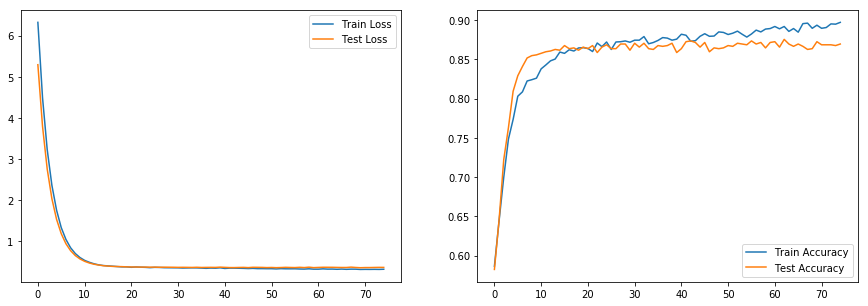

In [25]:
# What do the results look like?
fig, ax = plt.subplots(figsize = (15, 5), ncols = 2)
ax[0].plot(results.history['loss'], label = 'Train Loss')
ax[0].plot(results.history['val_loss'], label = 'Test Loss')

ax[1].plot(results.history['acc'], label = 'Train Accuracy')
ax[1].plot(results.history['val_acc'], label = 'Test Accuracy')
ax[0].legend()
ax[1].legend();

In [26]:
print(f"Lowest validation cross entropy: {results.history['val_loss'][-1]}")
print(f"Highest validation accuracy: {results.history['val_acc'][-1]}")

Lowest validation cross entropy: 0.3665353531663298
Highest validation accuracy: 0.8696939785176886


> Difference in binary crossentropy and accuracy indicates an overfitting problem. Test crossentropy levels out around `0.35`

## LSTM network
Attempting to replicate the state-of-the-art approach using a LSTM network.

In [4]:
# Reshape the feature arrays to be n_observations by n_frames by n_features 
# (one frame per observation as the MFCCs and deltas were averaged)
X_train_lstm = X_train.reshape(-1, 1, 72)
X_test_lstm = X_test.reshape(-1, 1, 72)

In [108]:
# Initializing the LSTM model
lstm = Sequential()
lstm.add(LSTM(units = 128, input_shape = (1,72), recurrent_regularizer = regularizers.l2(0.3)))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dense(1, activation = 'sigmoid'))
lstm.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

In [109]:
# Fitting the LSTM model
results = lstm.fit(X_train_lstm,
                    y_train, 
                    epochs = 150,
                    validation_data = [X_test_lstm, y_test],
                    verbose = 0
                    )

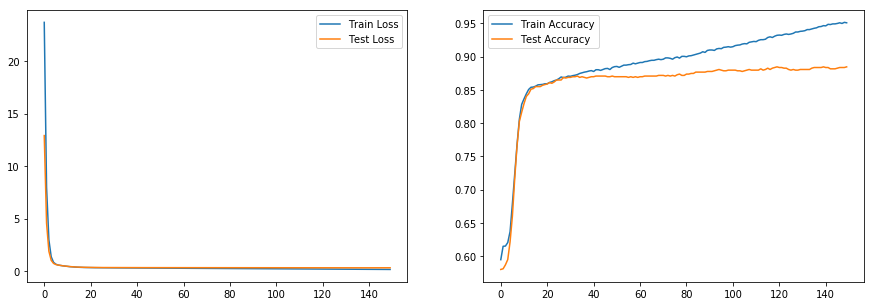

In [110]:
# What do the results look like?
fig, ax = plt.subplots(figsize = (15, 5), ncols = 2)
ax[0].plot(results.history['loss'], label = 'Train Loss')
ax[0].plot(results.history['val_loss'], label = 'Test Loss')

ax[1].plot(results.history['acc'], label = 'Train Accuracy')
ax[1].plot(results.history['val_acc'], label = 'Test Accuracy')
ax[0].legend()
ax[1].legend();

In [111]:
print(f"Lowest validation cross entropy: {min(results.history['val_loss'])}")
print(f"Highest validation accuracy: {max(results.history['val_acc'])}")

Lowest validation cross entropy: 0.30561567753229774
Highest validation accuracy: 0.8845014810444455


> Loss and accuracy scores on validation data have improved over the feedforward network. As it progresses through the training epochs there is still evidence of overfitting, but overall it is performing better on unseen data and as a result is a better model.

## Generating predicted labels for the validation segment

In [150]:
# Reshaping the validation segment feature set for the LSTM network
V_lstm = V.reshape(-1, 1, 72)

predictions = lstm.predict_classes(V_lstm)

Regenerating time series durations of predicted classes:

In [235]:
# Initialize with an empty list and zero duration
segments = []
duration = 0
for i in range(len(predictions) - 1):
    
    # If the next observation belongs to the same predicted class add one second to the duration
    if predictions[i] == predictions[i + 1]:
        duration += 1
    
    # If the next observation is different, we have crossed into a new predicted class
    else:
        if predictions[i][0] == 1:
            segment = {}
            segment['start'] = i - duration
            segment['duration'] = duration + 1
            segment['label'] = 'matt'
            segment['value'] = 100
            segments.append(segment)
        # Reset the duration for the next segment
        duration = 0

Creating a dataframe of the predicted segments and their durations, and writing to `.csv`

In [236]:
segments = pd.DataFrame(segments)
segments.to_csv('./data/validation/labels.csv', header = False)

## Results against validation audio segment

![Predictions](predictions.png "Predictions")

On the unseen validation audio segment, the model is overpredicting the positive class. This could be countered in the future by incorporating more data as well as a universal background model.
